In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import zipfile
from PIL import Image, ImageStat
import io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import random

2024-05-26 13:11:43.383544: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 13:11:43.974947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 13:11:45.134603: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:


batch_size = 32
img_height = 180
img_width = 180

def image_quality(image):
    gray = image.convert("L")
    stat = ImageStat.Stat(gray)
    return stat.stddev[0]


            

def apply_clahe(image, clip_limit,tile_grid_size):
    img_np = np.array(image)
    img_np = img_np[:, :, ::-1]  # Convert RGB to BGR
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_BGR2Lab)  # Convert to Lab color space
    l, a, b = cv2.split(img_lab)  # Split into channels
    tile_grid_size_int = int(tile_grid_size)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size_int, tile_grid_size_int))  # Apply CLAHE with specified parameters
    l_clahe = clahe.apply(l)  # Apply to L channel
    lab_clahe = cv2.merge((l_clahe, a, b))  # Merge back the channels
    img_clahe_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2BGR)  # Convert back to BGR
    img_clahe_rgb = img_clahe_bgr[:, :, ::-1]  # Convert BGR to RGB
    return Image.fromarray(img_clahe_rgb)

import concurrent.futures
from scipy.optimize import differential_evolution
def optimize_params(image):
    def objective(params):
        clip_limit, tile_grid_size = params
        try:
            img_clahe = apply_clahe(image, clip_limit, int(tile_grid_size))
            return -image_quality(img_clahe)
        except cv2.error:
            print("CV2 error")
            return np.inf
    bounds = [(2,5), (2,8)]
    result = differential_evolution(objective, bounds, strategy = 'best1bin', maxiter = 5, popsize=5, tol=0.01)
    return result.x

def apply_clahe_split(image, clip_limit,tile_grid_size):
    red,green,blue = image.split()
    # redM = ( 1,   0,  0, 0, 
    #        0,   0,  0, 0, 
    #        0,     0, 0, 0) 
    # greenM = ( 0,   0,  0, 0, 
    #        0,   0,  1, 0, 
    #        0,     0, 0, 0) 
    # blueM = ( 0,   0,  0, 0, 
    #        0,   0,  0, 0, 
    #        0,     0, 1, 0) 
    # red.convert("RGB").convert("RGB",redM).save("./example/redBefore.png")
    # green.convert("RGB").convert("RGB",greenM).save("./example/greenBefore.png")
    # blue.convert("RGB").convert("RGB",blueM).save("./example/blueBefore.png")
    redImage = apply_clahe(red.convert("RGB"), clip_limit,tile_grid_size)
    greenImage = apply_clahe(green.convert("RGB"), clip_limit,tile_grid_size)
    blueImage = apply_clahe(blue.convert("RGB"), clip_limit,tile_grid_size)
    # redImage.convert("RGB",redM).save("./example/redAfter.png")
    # greenImage.convert("RGB",greenM).save("./example/greenAfter.png")
    # blueImage.convert("RGB",blueM).save("./example/blueAfter.png")
    outputImage = Image.merge("RGB",(redImage.convert("L"),greenImage.convert("L"),blueImage.convert("L") ) )
    return outputImage
    
def apply_clahe_numpy(img_np,  clip_limit, tile_grid_size):
    img_np = img_np[:, :, ::-1]  # Convert RGB to BGR    
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_BGR2Lab)  # Convert to Lab color space
    l, a, b = cv2.split(img_lab)  # Split into channels
    tile_grid_size_int = int(tile_grid_size)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size_int, tile_grid_size_int))  # Apply CLAHE with specified parameters
    l_clahe = clahe.apply(l)  # Apply to L channel
    lab_clahe = cv2.merge((l_clahe, a, b))  # Merge back the channels
    img_clahe_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2BGR)  # Convert back to BGR
    img_clahe_rgb = img_clahe_bgr[:, :, ::-1]  # Convert BGR to RGB
    return img_clahe_rgb

def apply_clahe_optimized(image,i):
    clip_limit, tile_grid_size = optimize_params(image)
    if(i % 10 == 0):
        print("Params CLIP: " + str(clip_limit) + " - TILE: " +  str(tile_grid_size) )
    return apply_clahe(image, clip_limit, tile_grid_size)

In [3]:
# baseImg = PIL.Image.open("./low-quality-cropped/fake/29.png")
# imgFinal = apply_clahe_split(baseImg,3,15)
# imgFinal.save("./example/finalAfter.png")

In [4]:
face_cascade = cv2.CascadeClassifier("face_detectorzz.xml")
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [9]:
def apply_clahe_directory(inputDir, outputDir):
    names = glob(inputDir+ "/*.*")
    for name in names:
        fileName = name.split("/")[-1]
        image = PIL.Image.open(name)
        clahe = apply_clahe(image,3,15)
        clahe.save(outputDir + "/" + fileName[:-4] + ".png")
apply_clahe_directory("./low-quality-filtered/fake", "./low-quality-clahe/fake")
apply_clahe_directory("./low-quality-filtered/real", "./low-quality-clahe/real")

In [18]:
def apply_crop(inputDir, outputDir):
    names = glob(inputDir+ "/*.jpg")
    for name in names:
        fileName = name.split("/")[-1]
        image = cv2.imread(name)
        #print(image)
        #faces = face_cascade.detectMultiScale(image, 1.1, 4)
        faces = face_classifier.detectMultiScale(
        image, scaleFactor=1.1, minNeighbors=5, minSize=(90, 90)
        )
        maxH = 0
        maxW = 0
        x,y,w,h = (-1,-1,-1,-1)
        for (x_, y_, w_, h_) in faces:
            if(w_ * h_) > (w * h):
                x = x_
                y = y_
                w = w_
                h = h_
        if h == -1:
            continue
        if h != -1:
            yMin = max(y-10,0)
            xMin = max(x-10,0)
            image = image[yMin:y+h+10, xMin:x+w+10]
        imgrgb = image[:, :, ::-1]  # Convert BGR to RGB
        image = Image.fromarray(imgrgb)
        #cv2.imwrite(outputDir + "/" + fileName,image)
        image.save(outputDir + "/" + fileName[:-4] + ".png")
        imageInit = PIL.Image.open(name)
        imageInit.save("./low-quality-filtered/" + outputDir[-4:] + "/" + fileName[:-4] + ".png")
apply_crop("./low-quality/fake", "./low-quality-cropped/fake")
apply_crop("./low-quality/real", "./low-quality-cropped/real")

In [78]:
def apply_clahe_split_directory(inputDir, outputDir):
    names = glob(inputDir+ "/*.*")
    for name in names:
        fileName = name.split("/")[-1]
        image = PIL.Image.open(name)
        clahe = apply_clahe_split(image,3,15)
        clahe.save(outputDir + "/" + fileName[:-4] + ".png")
apply_clahe_split_directory("./low-quality-filtered/fake", "./low-quality-split/fake")
apply_clahe_split_directory("./low-quality-filtered/real", "./low-quality-split/real")

In [19]:
def apply_clahe_splitc_directory(inputDir, outputDir):
    names = glob(inputDir+ "/*.*")
    for name in names:
        fileName = name.split("/")[-1]
        image = PIL.Image.open(name)
        clahe = apply_clahe_split(image,3,12)
        clahe.save(outputDir + "/" + fileName[:-4] + ".png")
apply_clahe_splitc_directory("./low-quality-cropped/fake", "./low-quality-split-cropped/fake")
apply_clahe_splitc_directory("./low-quality-cropped/real", "./low-quality-split-cropped/real")

In [60]:
def apply_clahe_optimized_directory(inputDir, outputDir):
    names = glob(inputDir+ "/*.jpg")
    i = 0
    for name in names:
        i += 1
        if(i % 10 == 0):
            print("Round " + str(i))
        fileName = name.split("/")[-1]
        image = PIL.Image.open(name)
        clahe = apply_clahe_optimized(image,i)
        clahe.save(outputDir + "/" + fileName[:-4] + ".png")
apply_clahe_optimized_directory("./low-quality/fake", "./low-quality-opt/fake")
apply_clahe_optimized_directory("./low-quality/real", "./low-quality-opt/real")

Round 10
Params CLIP: 4.996992721122265 - TILE: 2.5950901646743834
Round 20
Params CLIP: 4.989106125878057 - TILE: 2.5586599460517663
Round 30
Params CLIP: 4.895643683692425 - TILE: 2.8203876147595555
Round 40
Params CLIP: 3.9996379486573166 - TILE: 3.0702789165990243
Round 50
Params CLIP: 4.989585684790023 - TILE: 2.396987829259603
Round 60
Params CLIP: 4.976207864115679 - TILE: 2.838795204144401
Round 70
Params CLIP: 2.0440506687450775 - TILE: 2.5866285640087936
Round 80
Params CLIP: 4.995444531967966 - TILE: 2.569237222960333
Round 90
Params CLIP: 4.927267556346186 - TILE: 2.4958971212487726
Round 100
Params CLIP: 4.9646471370693614 - TILE: 2.310913648982967
Round 110
Params CLIP: 4.978088211015011 - TILE: 2.9099783639430106
Round 120
Params CLIP: 4.930285423374024 - TILE: 2.247175295613371
Round 130
Params CLIP: 4.998505412467583 - TILE: 2.249744674645428
Round 140
Params CLIP: 4.516608171293349 - TILE: 2.799057000968285
Round 150
Params CLIP: 4.777980011419138 - TILE: 2.8651085161

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

def get_model(num_classes = 2):
    # input_shape = (global_image_dim, global_image_dim, 3)  
    # model = build_model(input_shape)
    # return model
    
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(180,
                                      180,
                                      3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )
    model = Sequential([
          data_augmentation,
          layers.Rescaling(1./255),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(128, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(256, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(256, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Dropout(0.2),
          layers.Flatten(),
          layers.Dense(256, activation='relu'),
          layers.Dense(num_classes, name="outputs")
        ])
    # model = Sequential([
    #       data_augmentation,
    #       layers.Rescaling(1./255),
    #       layers.Conv2D(64, 3, padding='same', activation='relu'),
    #       layers.MaxPooling2D(),
    #       layers.Conv2D(128, 3, padding='same', activation='relu'),
    #       layers.MaxPooling2D(),
    #       layers.Conv2D(128, 3, padding='same', activation='relu'),
    #       layers.MaxPooling2D(),
    #       #layers.Dropout(0.2),
    #       layers.Flatten(),
    #       layers.Dense(128, activation='relu'),
    #       layers.Dense(num_classes, name="outputs")
    #     ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    # input_shape = (global_image_dim, global_image_dim, 3)  
    # model = build_model(input_shape)
    return model






In [23]:
def get_datasets(data_dir):
    batch_size = 32
    img_height = 180
    img_width = 180
    train_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.20,
      subset="training",
      seed=123,
      image_size=(180,180),
      batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      validation_split=0.20,
      subset="validation",
      seed=123,
      image_size=(180,180),
      batch_size=batch_size)

    return train_ds, val_ds


def evaluate(directory):
    train_ds, val_ds = get_datasets(directory)
    model = get_model()
    epochs = 50
    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    return (val_acc, val_loss)



Found 1587 files belonging to 2 classes.
Using 1270 files for training.
Found 1587 files belonging to 2 classes.
Using 317 files for validation.
Epoch 1/50


2024-05-26 14:59:57.190679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_51_1/dropout_25_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.4805 - loss: 0.9042 - val_accuracy: 0.4984 - val_loss: 0.6926
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5152 - loss: 0.6926 - val_accuracy: 0.5016 - val_loss: 0.6931
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.4831 - loss: 0.6936 - val_accuracy: 0.5110 - val_loss: 0.6929
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5508 - loss: 0.6918 - val_accuracy: 0.6088 - val_loss: 0.6897
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5532 - loss: 0.6881 - val_accuracy: 0.6751 - val_loss: 0.6552
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6732 - loss: 0.6293 - val_accuracy: 0.7382 - val_loss: 0.5692
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7086 - loss: 0.5626 - val_accuracy: 0.8202 - val_loss: 0.4187
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7731 - loss: 0.4972 - val_accuracy: 0.8233 - val_loss: 0.

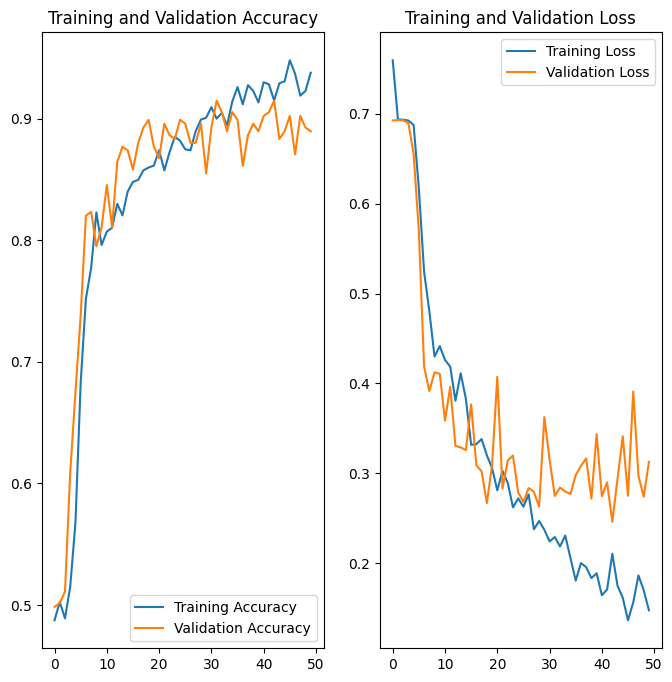

In [63]:
clahe_acc, clahe_loss = evaluate("low-quality-clahe")

Found 1587 files belonging to 2 classes.
Using 1349 files for training.
Found 1587 files belonging to 2 classes.
Using 238 files for validation.
Epoch 1/80


2024-05-26 13:26:32.096419: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.4854 - loss: 0.7725 - val_accuracy: 0.5420 - val_loss: 0.6925
Epoch 2/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5157 - loss: 0.6922 - val_accuracy: 0.4832 - val_loss: 0.6930
Epoch 3/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5238 - loss: 0.6917 - val_accuracy: 0.5588 - val_loss: 0.6865
Epoch 4/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5989 - loss: 0.6730 - val_accuracy: 0.5462 - val_loss: 0.6755
Epoch 5/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6166 - loss: 0.6531 - val_accuracy: 0.6050 - val_loss: 0.6598
Epoch 6/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6392 - loss: 0.6448 - val_accuracy: 0.7437 - val_loss: 0.5356
Epoch 7/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.7472 - loss: 0.5179 - val_accuracy: 0.7311 - val_loss: 0.5428
Epoch 8/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7667 - loss: 0.4926 - val_accuracy: 0.8277 - val_loss: 0.

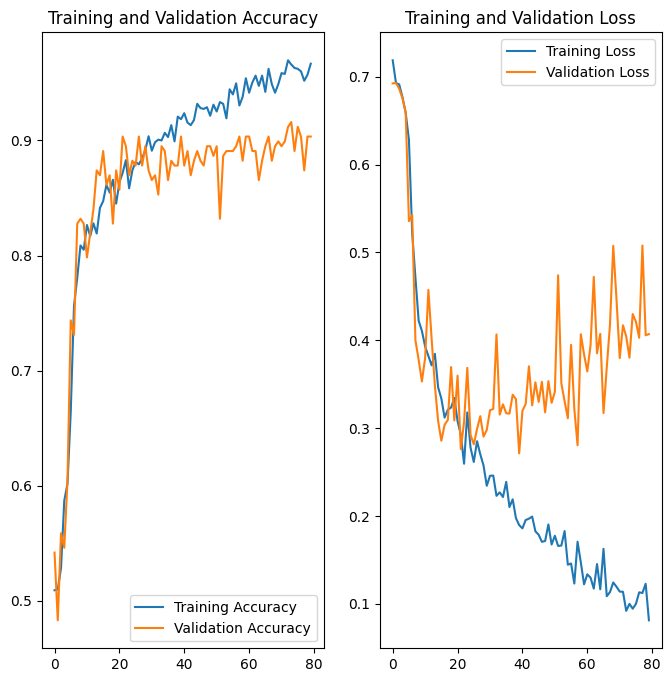

In [15]:
raw_acc, raw_loss = evaluate("low-quality-filtered")

Found 1587 files belonging to 2 classes.
Using 1270 files for training.
Found 1587 files belonging to 2 classes.
Using 317 files for validation.
Epoch 1/50


2024-05-26 18:50:52.831081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_53_1/dropout_26_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.4979 - loss: 0.9878 - val_accuracy: 0.5016 - val_loss: 0.6931
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.4873 - loss: 0.6932 - val_accuracy: 0.5394 - val_loss: 0.6928
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.5274 - loss: 0.6922 - val_accuracy: 0.5016 - val_loss: 0.6927
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.5042 - loss: 0.6926 - val_accuracy: 0.5110 - val_loss: 0.6837
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.5813 - loss: 0.6597 - val_accuracy: 0.7981 - val_loss: 0.4904
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.7434 - loss: 0.5302 - val_accuracy: 0.8233 - val_loss: 0.4128
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.7782 - loss: 0.4607 - val_accuracy: 0.8328 - val_loss: 0.4316
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.7945 - loss: 0.4564 - val_accuracy: 0.8297 - val

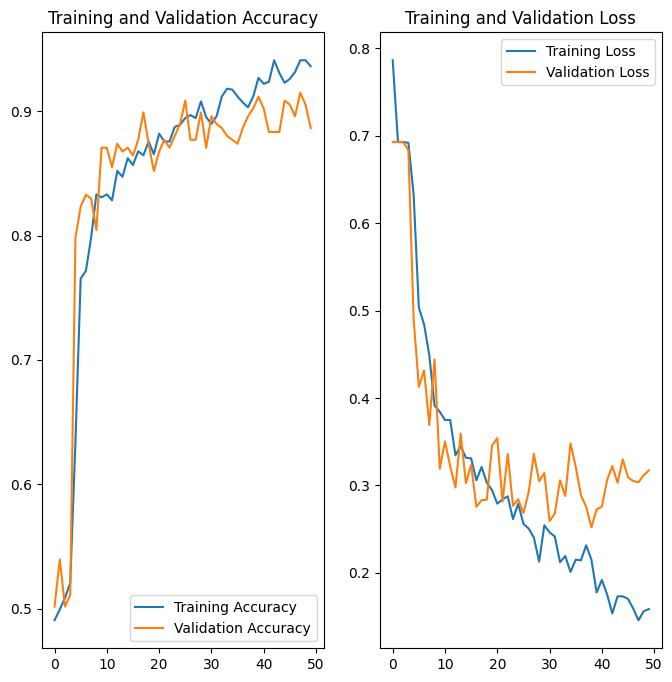

([0.5015772581100464,
  0.539432168006897,
  0.5015772581100464,
  0.511040985584259,
  0.7981072664260864,
  0.8233438730239868,
  0.8328076004981995,
  0.8296530246734619,
  0.8044164180755615,
  0.8706624507904053,
  0.8706624507904053,
  0.8548895716667175,
  0.8738170266151428,
  0.8675078749656677,
  0.8706624507904053,
  0.8643532991409302,
  0.8769716024398804,
  0.8990536332130432,
  0.8738170266151428,
  0.85173499584198,
  0.8675078749656677,
  0.8769716024398804,
  0.8706624507904053,
  0.8801261782646179,
  0.8895899057388306,
  0.9085173606872559,
  0.8769716024398804,
  0.8769716024398804,
  0.8990536332130432,
  0.8706624507904053,
  0.8958990573883057,
  0.8895899057388306,
  0.886435329914093,
  0.8801261782646179,
  0.8769716024398804,
  0.8738170266151428,
  0.886435329914093,
  0.8958990573883057,
  0.9022082090377808,
  0.9116719365119934,
  0.9022082090377808,
  0.8832807540893555,
  0.8832807540893555,
  0.8832807540893555,
  0.9085173606872559,
  0.905362784862

In [79]:
evaluate("low-quality-split")

Found 1727 files belonging to 2 classes.
Using 1382 files for training.
Found 1727 files belonging to 2 classes.
Using 345 files for validation.
Epoch 1/40


2024-05-24 05:23:38.921772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_49_1/dropout_24_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.4993 - loss: 1.0340 - val_accuracy: 0.4928 - val_loss: 0.6958
Epoch 2/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5050 - loss: 0.6947 - val_accuracy: 0.5681 - val_loss: 0.6911
Epoch 3/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5742 - loss: 0.6897 - val_accuracy: 0.5391 - val_loss: 0.6897
Epoch 4/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5420 - loss: 0.6889 - val_accuracy: 0.6319 - val_loss: 0.6547
Epoch 5/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5847 - loss: 0.6825 - val_accuracy: 0.6087 - val_loss: 0.6458
Epoch 6/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6175 - loss: 0.6530 - val_accuracy: 0.6522 - val_loss: 0.6296
Epoch 7/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.6322 - loss: 0.6422 - val_accuracy: 0.7594 - val_loss: 0.4959
Epoch 8/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.7283 - loss: 0.5684 - val_accuracy: 0.7884 - val_loss: 0.

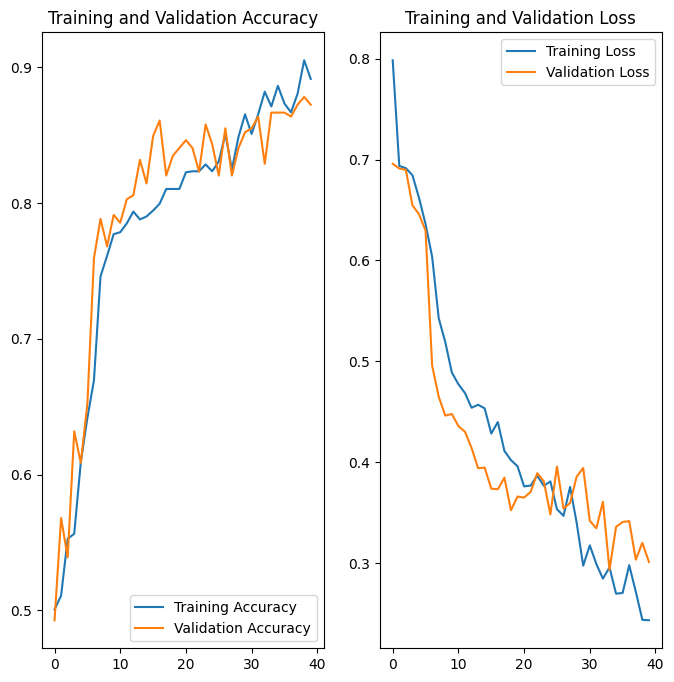

In [69]:
evaluate("low-quality-opt")

Found 1587 files belonging to 2 classes.
Using 1270 files for training.
Found 1587 files belonging to 2 classes.
Using 317 files for validation.
Epoch 1/50


2024-05-26 14:57:20.393952: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_49_1/dropout_24_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5153 - loss: 0.8619 - val_accuracy: 0.4984 - val_loss: 0.6928
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.5145 - loss: 0.6923 - val_accuracy: 0.5268 - val_loss: 0.6926
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5536 - loss: 0.6906 - val_accuracy: 0.5016 - val_loss: 0.7150
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5902 - loss: 0.6708 - val_accuracy: 0.7476 - val_loss: 0.5852
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7361 - loss: 0.5525 - val_accuracy: 0.8328 - val_loss: 0.3671
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7910 - loss: 0.4287 - val_accuracy: 0.8233 - val_loss: 0.3947
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.8348 - loss: 0.3927 - val_accuracy: 0.8328 - val_loss: 0.3489
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.8315 - loss: 0.3678 - val_accuracy: 0.8486 - val_loss: 0.

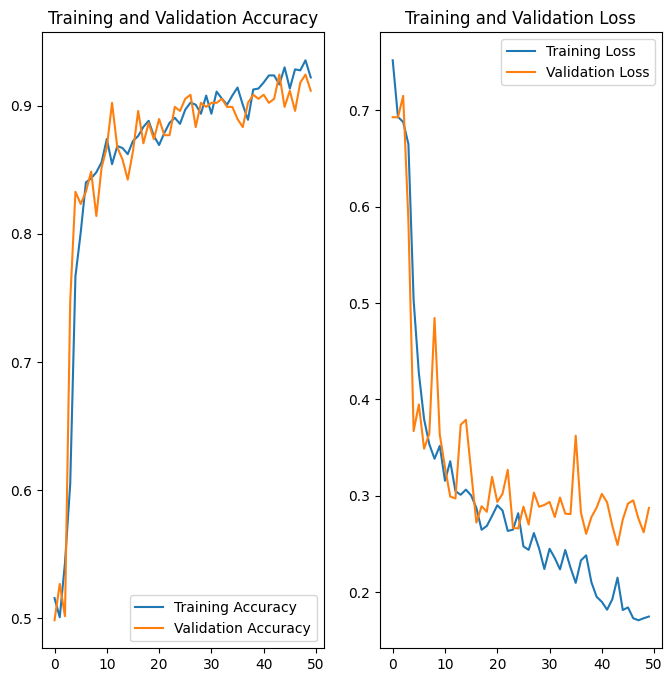

In [62]:
split_c_acc, split_c_loss = evaluate("low-quality-split-cropped")

Found 1587 files belonging to 2 classes.
Using 1270 files for training.
Found 1587 files belonging to 2 classes.
Using 317 files for validation.
Epoch 1/40


2024-05-24 05:32:32.997814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_55_1/dropout_27_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.5308 - loss: 0.9175 - val_accuracy: 0.5521 - val_loss: 0.6868
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.5745 - loss: 0.6763 - val_accuracy: 0.7350 - val_loss: 0.6063
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7122 - loss: 0.5815 - val_accuracy: 0.7666 - val_loss: 0.4912
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7614 - loss: 0.5057 - val_accuracy: 0.8013 - val_loss: 0.4501
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7979 - loss: 0.4480 - val_accuracy: 0.8170 - val_loss: 0.3963
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.8074 - loss: 0.4326 - val_accuracy: 0.7981 - val_loss: 0.4506
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.8230 - loss: 0.4321 - val_accuracy: 0.8454 - val_loss: 0.3720
Epoch 8/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8213 - loss: 0.4108 - val_accuracy: 0.8328 - val_loss: 0

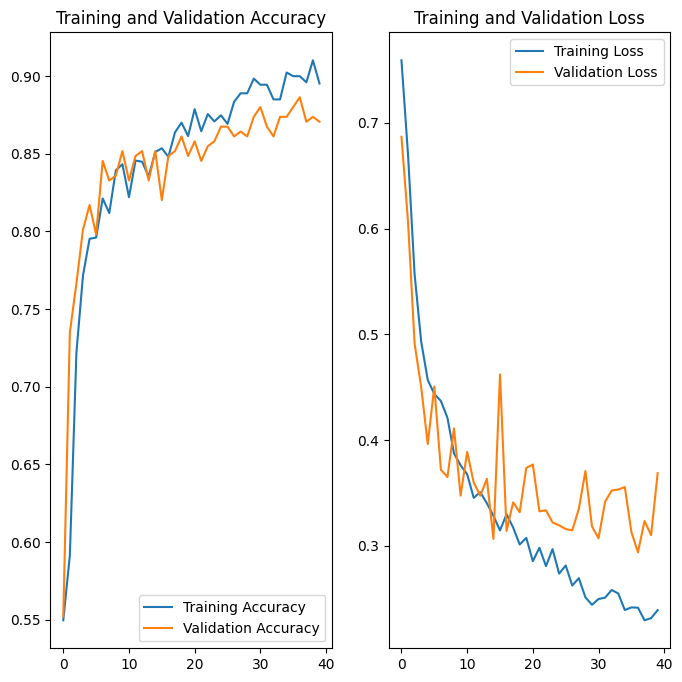

In [75]:
evaluate("low-quality-cropped")

In [26]:
clahe_accs = []
clahe_losses = []
splitc_accs = []
splitc_losses = []

In [52]:
from copy import deepcopy

clahe_accs.append(deepcopy(clahe_acc))
clahe_losses.append(deepcopy(clahe_loss))
splitc_accs.append(deepcopy(split_c_acc))
splitc_losses.append(deepcopy(split_c_loss))

In [73]:
import heapq
print("Standard CLAHE")
claheAverageAcc = 0
for accs in clahe_accs:
    print(heapq.nlargest(5,accs))
    claheAverageAcc += sum(heapq.nlargest(5,accs)) / 5
claheAverageAcc /= len(clahe_accs)

claheAverageLoss = 0
for losses in clahe_losses:
    print(heapq.nsmallest(5,losses))
    claheAverageLoss += sum(heapq.nsmallest(5,losses)) / 5
claheAverageLoss /= len(clahe_losses)
print("Average Accuracy: " + str(claheAverageAcc))
print("Average Loss: " + str(claheAverageLoss))

print("-----------------------")
print("Split CLAHE and Cropped")
splitAverageAcc = 0
for accs in splitc_accs:
    print(heapq.nlargest(5,accs))
    splitAverageAcc += sum(heapq.nlargest(5,accs)) / 5
splitAverageAcc /= len(splitc_accs)

splitAverageLoss = 0
for losses in splitc_losses:
    print(heapq.nsmallest(5,losses))
    splitAverageLoss += sum(heapq.nsmallest(5,losses)) / 5
splitAverageLoss /= len(splitc_losses)
print("Average Accuracy: " + str(splitAverageAcc))
print("Average Loss: " + str(splitAverageLoss))

Standard CLAHE
[0.9116719365119934, 0.9085173606872559, 0.9085173606872559, 0.9053627848625183, 0.9022082090377808]
[0.9242902398109436, 0.921135663986206, 0.914826512336731, 0.914826512336731, 0.9116719365119934]
[0.921135663986206, 0.921135663986206, 0.921135663986206, 0.921135663986206, 0.9179810881614685]
[0.914826512336731, 0.914826512336731, 0.9116719365119934, 0.9116719365119934, 0.9053627848625183]
[0.9116719365119934, 0.9085173606872559, 0.9085173606872559, 0.9053627848625183, 0.9053627848625183]
[0.2597285211086273, 0.2605438232421875, 0.2619186043739319, 0.26274359226226807, 0.26284533739089966]
[0.23673787713050842, 0.2428158074617386, 0.2447446882724762, 0.24854184687137604, 0.24990449845790863]
[0.2270544469356537, 0.22754472494125366, 0.2286086231470108, 0.22977319359779358, 0.23064294457435608]
[0.24088913202285767, 0.25709766149520874, 0.2580049932003021, 0.26875948905944824, 0.2694188058376312]
[0.24547772109508514, 0.2564913034439087, 0.2587505280971527, 0.2618933320

In [69]:
mergedClaheAcc = np.array(clahe_accs[0])
for i in range(1,len(clahe_accs)):
    mergedClaheAcc += np.array(clahe_accs[i])
mergedClaheAcc /= len(clahe_accs)

mergedClaheLoss = np.array(clahe_losses[0])
for i in range(1,len(clahe_losses)):
    mergedClaheLoss += np.array(clahe_losses[i])
mergedClaheLoss /= len(clahe_losses)

splitcAcc = np.array(splitc_accs[0])
for i in range(1,len(splitc_accs)):
    splitcAcc += np.array(splitc_accs[i])
splitcAcc /= len(splitc_accs)

splitcLoss = np.array(splitc_losses[0])
for i in range(1,len(splitc_losses)):
    splitcLoss += np.array(splitc_losses[i])
splitcLoss /= len(splitc_losses)

Text(0.5, 1.0, 'Standard vs New Accuracy')

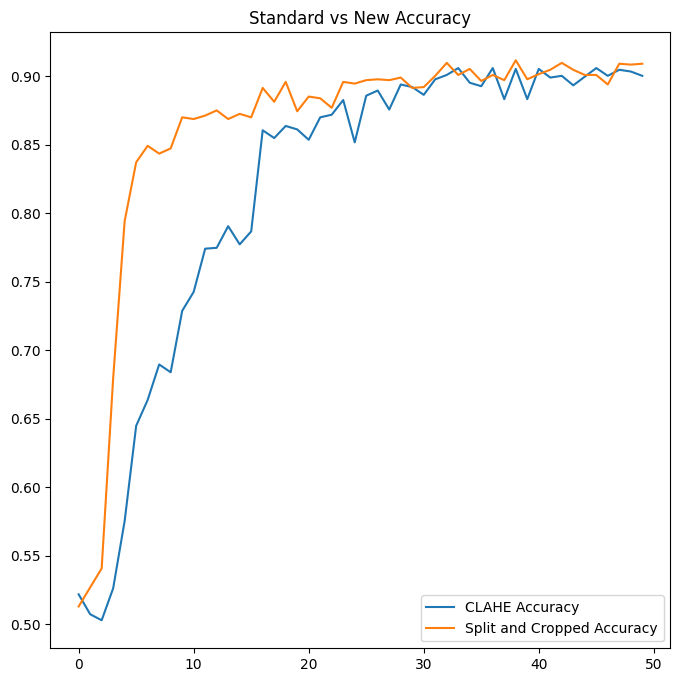

In [74]:
epochs_range = range(len(clahe_accs[0]))
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, mergedClaheAcc, label='CLAHE Accuracy')
plt.plot(epochs_range, splitcAcc, label='Split and Cropped Accuracy')
plt.legend(loc='lower right')
plt.title('Standard vs New Accuracy')

Text(0.5, 1.0, 'Standard vs New Loss')

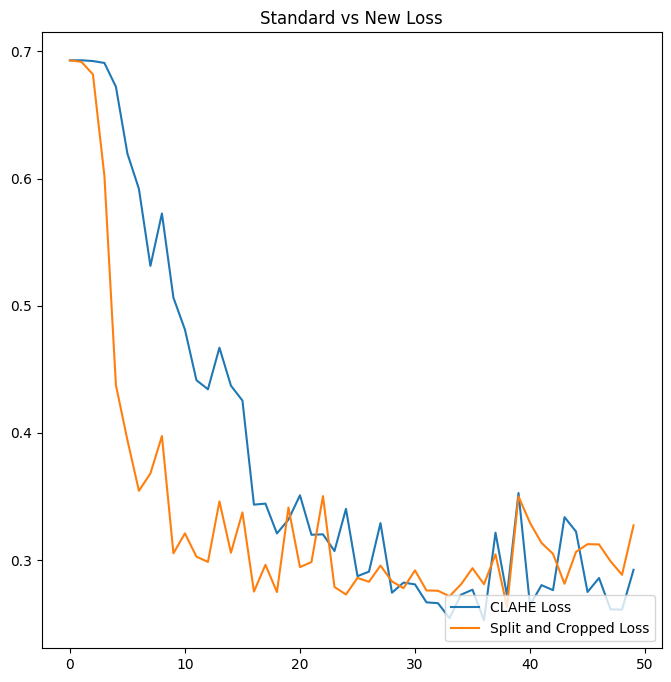

In [71]:
epochs_range = range(len(clahe_accs[0]))
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, mergedClaheLoss, label='CLAHE Loss')
plt.plot(epochs_range, splitcLoss, label='Split and Cropped Loss')
plt.legend(loc='lower right')
plt.title('Standard vs New Loss')